In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_bam import *

In [5]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

In [21]:
obsfiles=['../../datasets/gbins/bam/2017-07-02/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(19,50)]
obsfile = obsfiles[1]

#obsfiles=['../../datasets/gbins/bam/09-2017/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(0,20)]
#obsfile = obsfiles[11]

nobs = 500 # how many obs we want to do - although this is an upper limit
i_obs = 0

In [22]:
i_obs = 0

# build two boxcars
boxrad = 3
npatterns = boxrad*2 + 1

boxcar0 = np.zeros((npatterns, 1000, 80))
boxcar1 = np.zeros((npatterns, 1000, 80))

# fill them
i_rep0 = 0
i_rep1 = 0
i_sig0 = 0
i_sig1 = 0
n0 = 0
n1 = 0

# open the reader
reader = gbin_reader.GbinReader(obsfile)

# record acquisition times
acqTimes = []

# fill the first few elements
while True:
    (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
    if fov == None:
        break  # should raise an error here - this should never happen
    if fov==0 and n0 < npatterns:
        (i_rep0, i_sig0) = boxcar_update(boxcar0, pattern, i_rep0, i_sig0)
        n0 += 1
    elif fov==1 and n1 < npatterns:
        (i_rep1, i_sig1) = boxcar_update(boxcar1, pattern, i_rep1, i_sig1)
        n1 += 1
    acqTimes.append(acqTime)
    i_obs += 1
    print(i_obs)
    if (n0 >= npatterns and n1 >= npatterns) or (i_obs >= nobs):
        break

# set the i_sig
i_sig0 = boxrad
i_sig1 = boxrad

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [23]:
# let's test the execution time of this part - it takes the most time
import time
tstart = time.time()


# extract the cosmics
out0 = []
out1 = []

while ((i_obs < nobs) and fov !=None):
    # extract cosmics from fov 0 and 1 and save them
    sig, err = boxcar_signal(boxcar0, i_sig0, readnoise)
    out0.append(boxcar_cosmics(sig, err, 4, 0.5))
    
    sig, err = boxcar_signal(boxcar1, i_sig1, readnoise)
    out1.append(boxcar_cosmics(sig, err, 4, 0.5))
    
    # update the boxcars
    for ii in range(2):
        (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
        if fov == None:
            break  # we're finished
        acqTimes.append(acqTime)
        if fov==0:
            (i_rep0, i_sig0) = boxcar_update(boxcar0, pattern, i_rep0, i_sig0)
            n0 += 1
        elif fov==1:
            (i_rep1, i_sig1) = boxcar_update(boxcar1, pattern, i_rep1, i_sig1)
            n1 += 1
        i_obs += 1
        #print(i_obs)

# add the acquisition times
# might want to move this into the previous step, this is somewthat annoying

for ii in range(len(out0)):
    out0[ii]["acqTime"] = acqTimes[2*ii + 1 + 2*boxrad]
    out1[ii]["acqTime"] = acqTimes[2*ii + 2*boxrad]
    
# also need to compute/know the end times!
        
        
tend = time.time()
print("Elapsed time:", tend - tstart)

/home/ckirsch/git/cosmics/analysis/bam/extraction_bam.py:95: RuntimeWarning: invalid value encountered in sqrt
  err_mean = np.sqrt(var_mean + readnoise*readnoise + boxcar[i_sig,:,:])


Elapsed time: 103.84931921958923


# Some diagnostics

In [25]:
print(len(out0[0]["cosmics"]))
#print(out0[0][9])

104


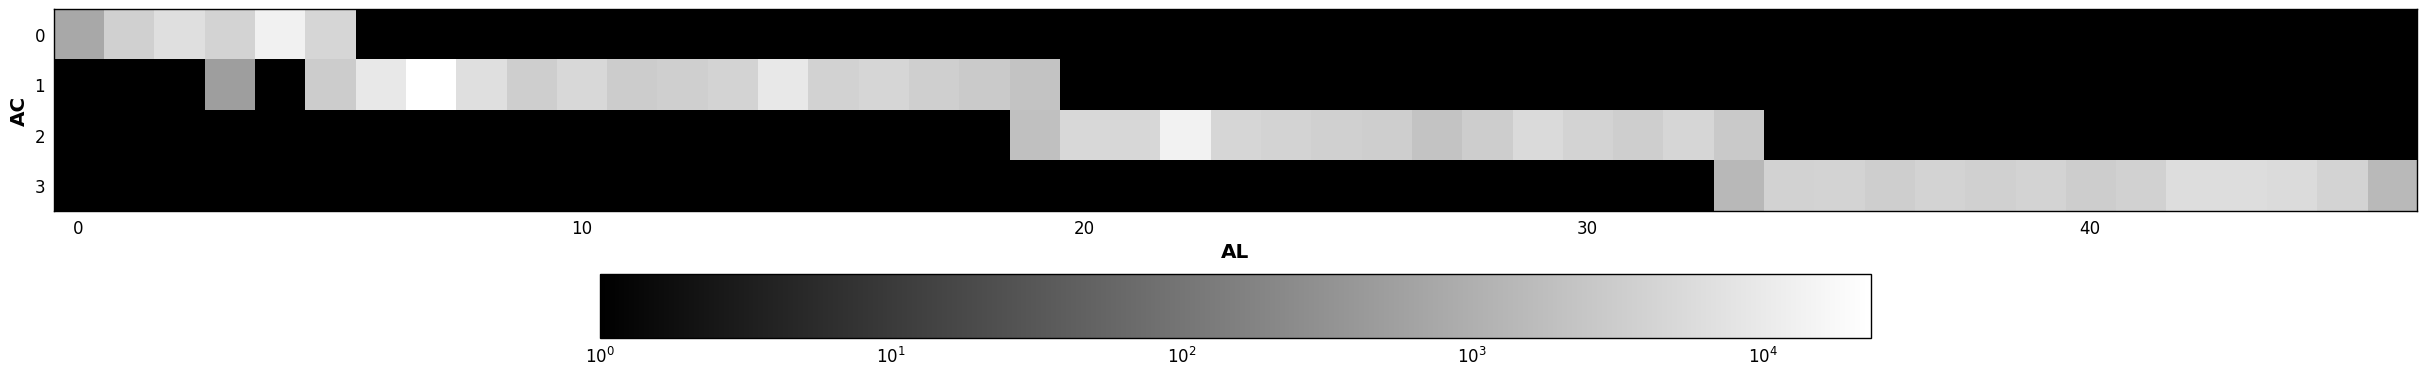

In [26]:
#image = np.rot90(sig/err,1)
image = np.rot90(out0[0]["cosmics"][9],1)
#image = np.rot90(out0[0][3],1)

plt.xlabel('AL')
plt.ylabel('AC')
#plt.imshow(image, cmap='gray',vmin=4, vmax=4.1)
plt.imshow(image+1, cmap='gray',vmin=1,norm=LogNorm())
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [27]:
# This should be quite a lot of energies, so do a histogram

E0 = []
E1 = []

# also for lengths, why not
AL0 = []
AL1 = []
AC0 = []
AC1 = []

for ii in range(len(out0)):
    for jj in range(len(out0[ii]["Etot"])):
        E0.append(out0[ii]["Etot"][jj])
        (AL,AC) = (out0[ii]["cosmics"][jj]).shape
        AL0.append(AL-1)
        AC0.append(AC-1)
    for jj in range(len(out1[ii]["Etot"])):
        E1.append(out1[ii]["Etot"][jj])
        (AL,AC) = (out1[ii]["cosmics"][jj]).shape
        AL1.append(AL-1)
        AC1.append(AC-1)

E0 = np.array(E0)
E1 = np.array(E1)
AL0 = np.array(AL0)
AC0 = np.array(AC0)
AL1 = np.array(AL1)
AC1 = np.array(AC1)

        
# number of cosmics
print("FOV 0:", len(E0), "cosmics")
print("FOV 1:", len(E1), "cosmics")

FOV 0: 10415 cosmics
FOV 1: 10546 cosmics


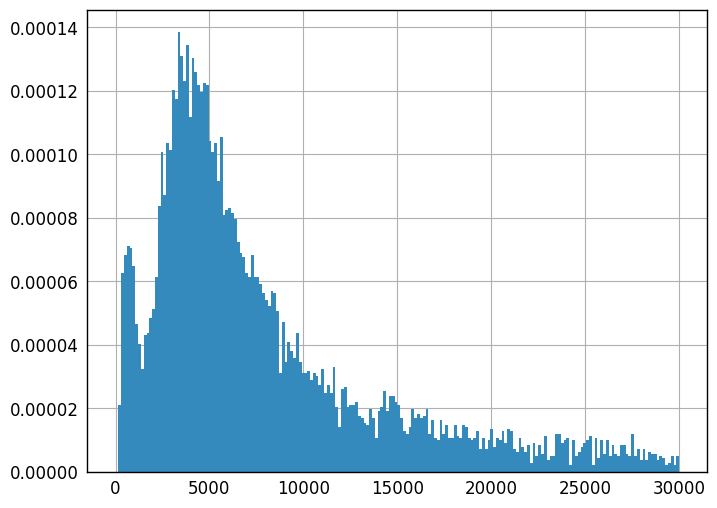

In [28]:
hist0 = plt.hist(E0, 200, log=False ,range=(0,30000), normed=True)

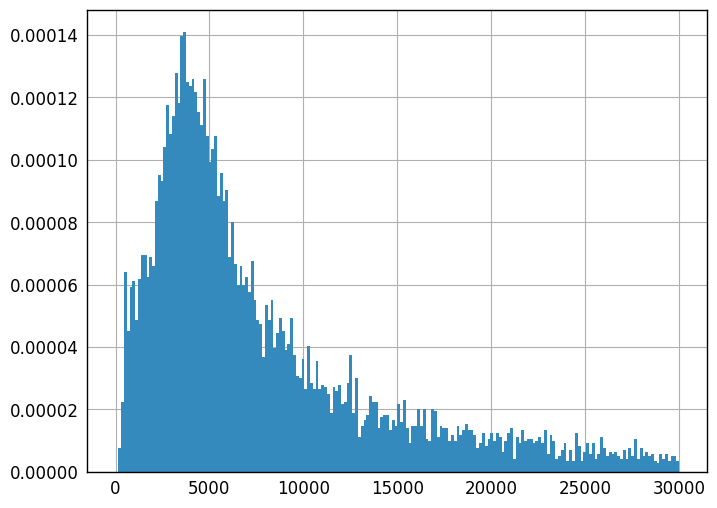

In [29]:
hist1 = plt.hist(E1, 200, log=False ,range=(0,30000), normed=True)

In [30]:
# Let's try the angles
# For now without how it faces

lx = AL0*10  # mum
ly = AC0*120 # mum

theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

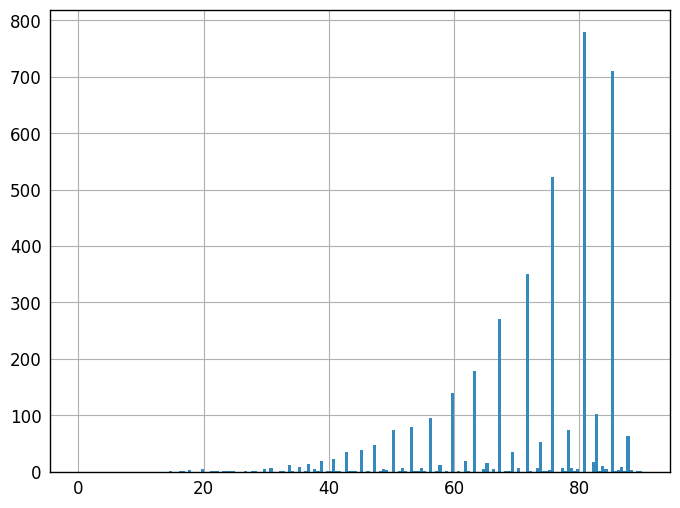

In [31]:
thist = plt.hist(theta,180,range=(0,90))

-> VERY biased

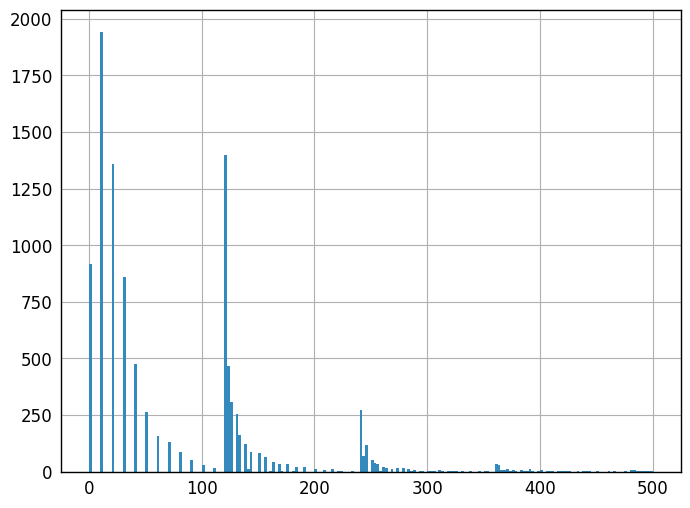

In [32]:
lengths = np.sqrt(lx*lx + ly*ly)

thist = plt.hist(lengths,200,range=(0,500),log=False)

One sees individual contributions from the length in AC and AL.

Fun estimation: Let's see if dE/dx gives us anything

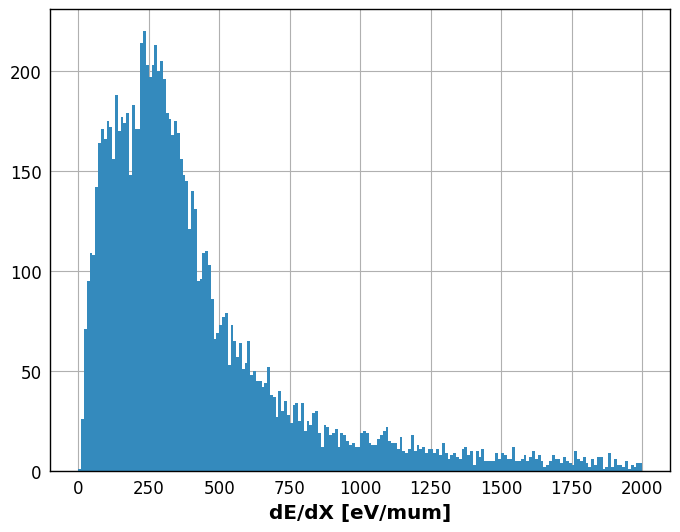

In [33]:
dEdx = E0/np.sqrt(lengths**2+40**2) # assuming our length measurement is good and we excite the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

I have to say, this looks remarkably like a landau distribution.

(It should not be, since we have multiple particle species/energies)

-> For normal obs: maximum at about 250 eV/mum = 2.5 MeV/cm = (for silicon) about 1 MeV cm2 / g

-> Minimum Ionizing Particle? That's about 1 GeV!

-> For Flare: also very Landau, max at about 500 eV/mum = 5 MeV/cm = 2 MeV cm2 / g

-> Either higher or lower energies - hard to say, since close to MIP

(Note: This is still all very suspect)

However, it's actually consistent with the paper by Jos using the Creme-background of the GCR (1 GeV) and Spenvis solar protons (10-10^2 MeV)...